# QTS Project  
## Option Wheel Strategy

This project studies a systematic options wheel strategy implemented on listed American equity options. The framework integrates multi-factor stock selection with option premium harvesting under a margin-based capital structure.



---

**Course:** Quantitative Trading Strategy  
**Group:** Final Project Group PF: J 

**Group Members**

- **Name**: Mingshu Lu   **Student ID**: 12496646
- **Name**: Jackie Zhang   **Student ID**: 12498155
- **Name**: Theo Li          **Student ID**: 12503045
- **Name**: Jessica Xu       **Student ID**: 12503042
- **Name**: Catherine Chen   **Student ID**: 12496600

# 1. Project Overview

This project studies a systematic options wheel strategy implemented on listed American-style equity options written on U.S. large-cap stocks. The framework combines equity selection and option premium harvesting within a unified backtesting structure. The objective is to evaluate whether disciplined short-volatility exposure, when applied to a selected set of liquid underlying equities, can generate attractive risk-adjusted returns over an extended sample period.

The strategy operates through monthly rolling option positions while maintaining a multi-year investment horizon to ensure exposure across different market regimes. Both assignment and premium collection dynamics are explicitly modeled, allowing the portfolio to alternate between cash-secured puts and covered calls. Capital allocation, transaction costs, and execution frictions are incorporated to ensure realistic performance estimation.

The backtest spans more than five years and includes at least five distinct underlying equities, generating sufficient trade frequency for statistical evaluation. Performance is assessed across full-sample and stressed market environments in order to evaluate robustness under varying volatility conditions.

# 2. Data Loading, Cleaning, and Engineering Pipeline

This section defines the data infrastructure and preprocessing pipeline used to construct the research dataset. The objective is to transform raw equity and option data into a clean, aligned panel suitable for signal construction and backtesting.

The data sources are as follows:

- Daily listed option data from Databento API
- Daily equity price data from Nasdaq Data Link
- Daily stock fundamental data and analyst consensus data from WRDS / IBES

All datasets are aligned to a common trading calendar and indexed by date and underlying ticker.

---

## 2.1 Equity Data Loading and Cleaning

This subsection loads daily equity price data from Nasdaq Data Link and merges it with fundamental and analyst consensus variables from WRDS / IBES. The dataset includes adjusted close prices, market capitalization, sector classification, and factor-related inputs.

The preprocessing procedure includes filtering the backtest period, removing securities with insufficient history, handling missing values, and constructing daily returns. Daily return is defined as:

$$
r_t = \frac{P_t}{P_{t-1}} - 1
$$

The output of this step is a cleaned equity panel indexed by date and ticker, which serves as the foundation for factor ranking and portfolio construction.

We just use the apis to get an example data of AAPL as draft. We'll use fetch all needed data during backtest using API calls.

In [ ]:
import wrds
import pandas as pd

db = wrds.Connection()


In [14]:
# 1) AAPL permno
permno = db.raw_sql("""
select permno
from crsp.stocknames
where ticker='AAPL'
order by nameenddt desc
limit 1
""").iloc[0, 0]

# 2) 2025 daily (CRSP dsf)
px = db.raw_sql(f"""
select date, permno, prc, ret, vol
from crsp.dsf
where permno = {int(permno)}
  and date between '2024-01-01' and '2024-12-31'
order by date
""")

px["date"] = pd.to_datetime(px["date"])
px["prc"] = px["prc"].abs()

In [15]:
px

,date,permno,prc,ret,vol
0,2024-01-02,14593,185.64,-0.035787,81752737.0
1,2024-01-03,14593,184.25,-0.007488,58136569.0
2,2024-01-04,14593,181.91,-0.0127,71280275.0
3,2024-01-05,14593,181.17999,-0.004013,62064040.0
4,2024-01-08,14593,185.56,0.024175,58748031.0
...,...,...,...,...,...
247,2024-12-24,14593,258.20001,0.011478,23146511.0
248,2024-12-26,14593,259.01999,0.003176,27065955.0
249,2024-12-27,14593,255.59,-0.013242,42079549.0
250,2024-12-30,14593,252.2,-0.013263,35147648.0


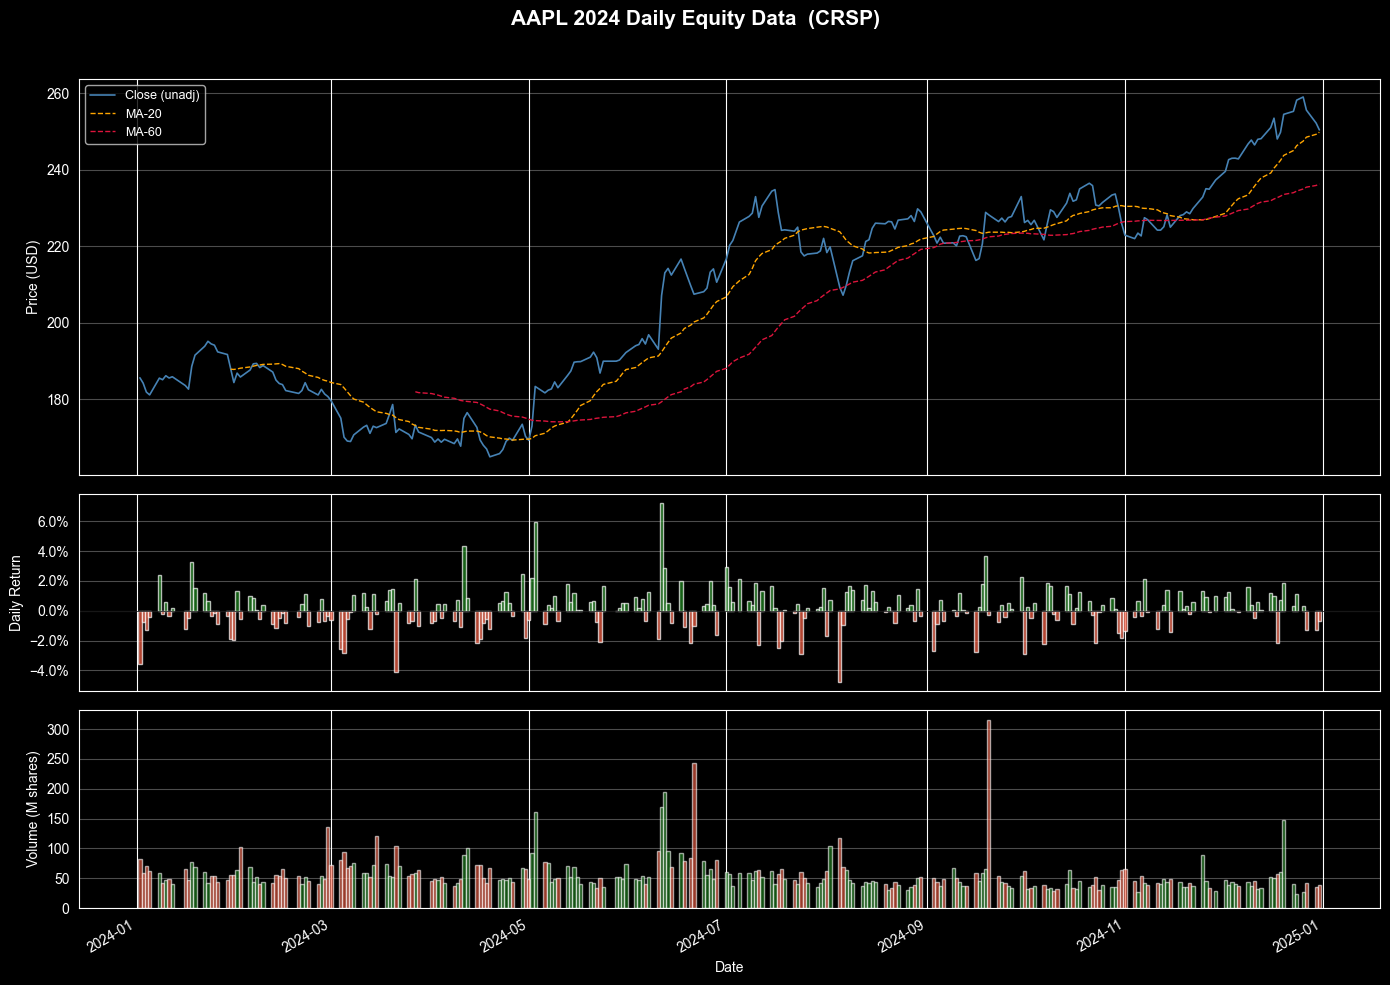

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                         gridspec_kw={"height_ratios": [3, 1.5, 1.5]})
fig.suptitle("AAPL 2024 Daily Equity Data  (CRSP)", fontsize=15, fontweight="bold")

# ── 1) price trend + 20 / 60 daily average ──
ax1 = axes[0]
ax1.plot(px["date"], px["prc"], color="steelblue", linewidth=1.2, label="Close (unadj)")
ax1.plot(px["date"], px["prc"].rolling(20).mean(),
         color="orange", linewidth=1, linestyle="--", label="MA-20")
ax1.plot(px["date"], px["prc"].rolling(60).mean(),
         color="crimson", linewidth=1, linestyle="--", label="MA-60")
ax1.set_ylabel("Price (USD)")
ax1.legend(loc="upper left", fontsize=9)
ax1.grid(axis="y", alpha=0.3)

# ── daily return ──
ax2 = axes[1]
colors_ret = np.where(px["ret"] >= 0, "forestgreen", "tomato")
ax2.bar(px["date"], px["ret"], color=colors_ret, width=1.0, alpha=0.7)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_ylabel("Daily Return")
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
ax2.grid(axis="y", alpha=0.3)

# ── volume ──
ax3 = axes[2]
colors_vol = np.where(px["ret"] >= 0, "forestgreen", "tomato")
ax3.bar(px["date"], px["vol"] / 1e6, color=colors_vol, width=1.0, alpha=0.6)
ax3.set_ylabel("Volume (M shares)")
ax3.set_xlabel("Date")
ax3.grid(axis="y", alpha=0.3)

fig.autofmt_xdate(rotation=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



---

## 2.2 Option Data Loading and Cleaning

This subsection loads daily option data from Databento API. The raw dataset includes option price, strike, expiration date, implied volatility, option delta, and open interest.

Contracts are filtered to approximately 4-week maturity in order to match the monthly rolling design of the wheel strategy. Illiquid contracts are removed based on open interest thresholds. Option records are merged with underlying equity prices to ensure pricing consistency.

The output is an aligned option panel indexed by date, underlying ticker, and contract characteristics.



We also use AAPL options data as an example to show the data loading and cleaning process. In the actual backtest, we'll fetch all needed data using API calls. We choose "2024-01-02" , the first trading day of 2024, as the snapshot date for this example.

### Figure: AAPL Options Overview (OPRA · 2024-01-02 Snapshot)

The figure above presents a four-panel visualization of AAPL listed option activity on the first trading day of 2024, constructed from OPRA daily OHLCV data via Databento.

| Panel | Title | Description |
|-------|-------|-------------|
| **Top-Left** | Volume by Strike (Call vs Put) | Displays aggregated trading volume across all expirations for each strike price. Call volume is plotted upward and put volume downward, forming a butterfly-shaped profile centered around the spot price (\$185.64). This reveals where the majority of hedging and speculative activity is concentrated. |
| **Top-Right** | Call Price vs Strike (Top 4 Expirations) | Plots the closing price of call options against strike price for the four most actively traded expiration dates. The characteristic convex payoff curve is visible: deep in-the-money calls carry high intrinsic value while far out-of-the-money calls converge toward zero. The vertical dashed line marks the underlying spot price. |
| **Bottom-Left** | Volume by Expiration Date | Compares total call and put volume across all available expiration dates. Near-term weekly expirations (e.g., Jan 5, Jan 12) exhibit substantially higher volume than longer-dated monthly or LEAPS expirations, consistent with the known concentration of liquidity in short-dated contracts. |
| **Bottom-Right** | Contract Count by Strike | Shows the number of distinct option contracts (across all expirations) listed at each strike price, stacked by call and put. This illustrates the density of the listed strike grid and highlights that strikes near the at-the-money region have the broadest expiration coverage. |

**Data source:** OPRA OHLCV-1d via Databento Historical API (`OPRA.PILLAR`), merged with instrument definitions.
**Underlying spot reference:** AAPL close = \$185.64 (CRSP daily, 2024-01-02).

In [18]:
import databento as db
client = db.Historical("db-jJRdxLiKfaP6gxtpeQtK5wwdc9Qtu")


In [29]:
data = client.timeseries.get_range(
    dataset="OPRA.PILLAR",
    schema="definition",
    stype_in="parent",
    symbols="AAPL.OPT",
    start="2024-01-02",
)
df = data.to_df()

In [30]:
df = df[["instrument_id","strike_price", "expiration", "instrument_class"]]

In [28]:
data2 = client.timeseries.get_range(
    dataset="OPRA.PILLAR",
    schema="OHLCV-1d",
    stype_in="parent",
    symbols="AAPL.OPT",
    start="2024-01-02",
)
df2 = data2.to_df()

In [31]:
df2.drop(columns=["rtype", "publisher_id"], inplace=True)

In [32]:
df2_agg = df2.groupby("instrument_id").agg(
    {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }
).reset_index()

In [33]:
merged = df2_agg.reset_index().merge(df, on="instrument_id", how="left")

In [34]:
merged.sort_values(by=["expiration","instrument_class", "strike_price"], inplace=True)

In [36]:
merged.reset_index(drop=True, inplace=True)
merged.drop(columns=["index"], inplace=True)

In [37]:
merged

,instrument_id,open,high,low,close,volume,strike_price,expiration,instrument_class
0,395,54.61,54.61,54.61,54.61,1,130.0,2024-01-05 00:00:00+00:00,C
1,3108,46.45,46.89,46.45,46.89,2,140.0,2024-01-05 00:00:00+00:00,C
2,4910,36.92,36.92,36.92,36.92,1,150.0,2024-01-05 00:00:00+00:00,C
3,3093,29.73,30.81,29.73,30.75,11,155.0,2024-01-05 00:00:00+00:00,C
4,398,27.56,28.10,24.35,24.35,101,160.0,2024-01-05 00:00:00+00:00,C
...,...,...,...,...,...,...,...,...,...
1092,16789742,26.80,27.30,26.30,26.85,21,200.0,2026-01-16 00:00:00+00:00,P
1093,16792828,30.05,30.05,30.04,30.05,4,205.0,2026-01-16 00:00:00+00:00,P
1094,16786794,32.00,32.05,31.90,31.90,4,210.0,2026-01-16 00:00:00+00:00,P
1095,16783942,38.00,38.00,38.00,38.00,2,220.0,2026-01-16 00:00:00+00:00,P


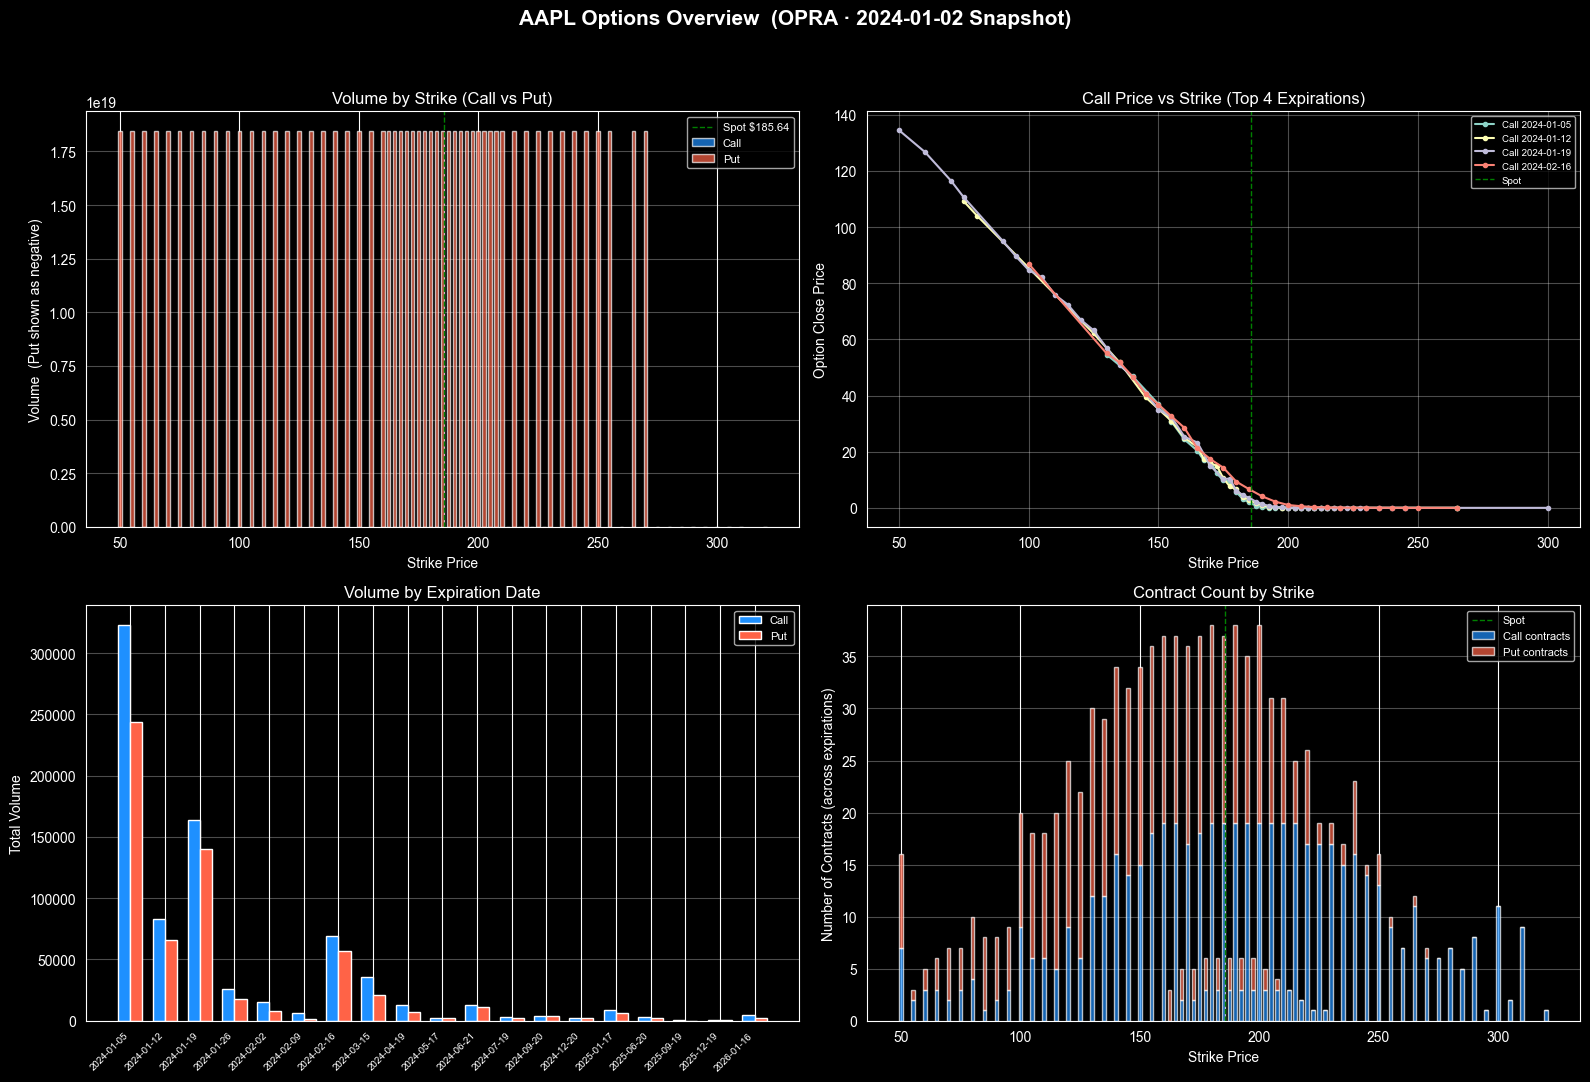

In [38]:

merged["expiration_date"] = merged["expiration"].dt.date
merged["dte"] = (merged["expiration"] - pd.Timestamp("2024-01-02", tz="UTC")).dt.days
calls = merged[merged["instrument_class"] == "C"]
puts  = merged[merged["instrument_class"] == "P"]

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle("AAPL Options Overview  (OPRA · 2024-01-02 Snapshot)",
             fontsize=15, fontweight="bold")


ax = axes[0, 0]
call_vol = calls.groupby("strike_price")["volume"].sum()
put_vol  = puts.groupby("strike_price")["volume"].sum()
ax.bar(call_vol.index, call_vol.values, width=1.5, alpha=0.7,
       color="dodgerblue", label="Call")
ax.bar(put_vol.index, -put_vol.values, width=1.5, alpha=0.7,
       color="tomato", label="Put")
ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(185.64, color="green", linestyle="--", linewidth=1, label="Spot $185.64")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Volume  (Put shown as negative)")
ax.set_title("Volume by Strike (Call vs Put)")
ax.legend(fontsize=8)
ax.grid(axis="y", alpha=0.3)


ax = axes[0, 1]
top_exp = merged.groupby("expiration_date")["volume"].sum().nlargest(4).index
for exp_date in sorted(top_exp):
    subset = calls[calls["expiration_date"] == exp_date]
    if len(subset) > 0:
        ax.plot(subset["strike_price"], subset["close"], marker="o",
                markersize=3, label=f"Call {exp_date}")
ax.axvline(185.64, color="green", linestyle="--", linewidth=1, label="Spot")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Option Close Price")
ax.set_title("Call Price vs Strike (Top 4 Expirations)")
ax.legend(fontsize=7, loc="upper right")
ax.grid(alpha=0.3)


ax = axes[1, 0]
vol_by_exp = merged.groupby(["expiration_date", "instrument_class"])["volume"].sum().unstack(fill_value=0)
x = np.arange(len(vol_by_exp))
w = 0.35
if "C" in vol_by_exp.columns:
    ax.bar(x - w/2, vol_by_exp["C"], width=w, color="dodgerblue", label="Call")
if "P" in vol_by_exp.columns:
    ax.bar(x + w/2, vol_by_exp["P"], width=w, color="tomato", label="Put")
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in vol_by_exp.index], rotation=45, ha="right", fontsize=7)
ax.set_ylabel("Total Volume")
ax.set_title("Volume by Expiration Date")
ax.legend(fontsize=8)
ax.grid(axis="y", alpha=0.3)


ax = axes[1, 1]
count_by_strike = merged.groupby(["strike_price", "instrument_class"]).size().unstack(fill_value=0)
ax.bar(count_by_strike.index, count_by_strike.get("C", 0),
       width=1.5, alpha=0.7, color="dodgerblue", label="Call contracts")
ax.bar(count_by_strike.index, count_by_strike.get("P", 0),
       width=1.5, alpha=0.7, color="tomato", bottom=count_by_strike.get("C", 0),
       label="Put contracts")
ax.axvline(185.64, color="green", linestyle="--", linewidth=1, label="Spot")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Number of Contracts (across expirations)")
ax.set_title("Contract Count by Strike")
ax.legend(fontsize=8)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 3. Strategy Architecture

This session defines the structural architecture of the strategy and clarifies how the equity selection layer interacts with the options execution layer. The objective is to establish a clear mapping between conceptual design and the implementation that follows in code.

The strategy consists of two interacting components:

1. A semiannual equity selection mechanism  
2. A monthly options wheel execution mechanism  

The equity layer determines the eligible stock universe at each rebalance date, while the option layer generates recurring premium income conditional on that selected universe.

Rebalance frequencies are defined as:

$$
T_{equity} = 6 \text{ months}
$$

$$
T_{option} = 4 \text{ weeks}
$$

The code in subsequent sections will construct these two timing cycles explicitly and implement their interaction within a unified backtesting engine.

# 4. Equity Selection Layer

This session constructs the equity selection mechanism that determines which underlying stocks are eligible for option writing. The objective is to formalize the stock ranking process and produce a time-indexed selected stock set.

The selection rule is based on a composite factor score defined as:

$$
Score_i = w_Q Q_i + w_M M_i + w_C C_i
$$

where $Q_i$, $M_i$, and $C_i$ denote standardized quality, momentum, and analyst consensus signals.

At each semiannual rebalance date, stocks are ranked cross-sectionally and the top-ranked securities are selected. The selected set is denoted as:

$$
\mathcal{S}_t = \{ i_1, i_2, ..., i_k \}
$$

The code in this session will compute factor signals, perform cross-sectional ranking, and construct the time-series of selected stock pools.

# 6. Option Wheel Mechanics

This session formalizes the mechanical implementation of the options wheel strategy. The objective is to translate the conceptual wheel process into executable trade rules.

For each selected stock, a 4-week out-of-the-money put is sold. Strike selection is determined by delta targeting, typically under 10-delta and 20-delta regimes. Assignment probability is approximated by:

$$
P(\text{assignment}) \approx |\Delta|
$$

If the put expires in-the-money, the underlying stock is assigned. The strategy then transitions to a covered call position. If the call expires in-the-money, the stock is called away and the process returns to a cash-secured put phase.

The code in this session will simulate option expiration outcomes, handle assignment logic, and implement the state transition between cash, stock holding, and covered call positions.

# 7. Capital Allocation and Margin Model

This session defines the capital base and leverage framework under which the strategy operates. The objective is to ensure that position sizing and funding costs are explicitly modeled.

Initial capital is defined as:

$$
C_0 = 2{,}000{,}000
$$

Position sizes are determined subject to margin requirements. If a Reg-T framework is applied, position exposure must satisfy:

$$
Exposure \leq \frac{Capital}{Margin\ Requirement}
$$

If assignment results in stock ownership, borrowing costs are incorporated through a funding rate $r_{borrow}$.

The code in this session will compute margin-adjusted position sizes, update available capital dynamically, and incorporate funding costs into portfolio PnL.

# 8. Transaction Costs and Execution Modeling

This session incorporates realistic execution assumptions into the backtest. The objective is to prevent overestimation of strategy performance.

Option commissions are modeled as:

$$
0.3 \text{ USD per contract}
$$

Slippage is modeled as:

$$
P_{exec} = P_{mid}(1 \pm 0.01)
$$

where execution price deviates by 1% from mid-price.

The code in this session will adjust trade prices for commission and slippage and produce both gross and net performance series.

# 9. Backtest Engine

This session integrates all previous components into a unified portfolio simulation framework. The objective is to generate a daily time series of portfolio value.

Portfolio value is defined as:

$$
V_t = C_t + \sum Equity_t + \sum Option_t
$$

where $C_t$ denotes cash balance, and positions are marked to market daily.

The code in this session will iterate through time, execute monthly option rolls, update assignment states, adjust capital, and record daily portfolio value.

# 10. Performance Evaluation

This session evaluates the performance of the strategy over the full sample and selected subperiods. The objective is to quantify return, risk, and drawdown characteristics.

Key performance measures include:

- Annualized return  
- Annualized volatility  
- Sharpe ratio  
- Maximum drawdown  
- Value-at-Risk (VaR)  

The code in this session will compute these metrics for both gross and net returns and compare them across volatility regimes.

# 11. Portfolio-Level Risk Analysis

This session examines portfolio-level risk exposures beyond simple return metrics. The objective is to assess robustness under stress conditions.

Risk dimensions include market exposure, concentration risk, liquidity risk, and cross-asset correlation between underlyings.

Stress periods such as high-volatility regimes are examined to evaluate downside sensitivity.

The code in this session will compute correlation matrices, exposure measures, and stress-period performance statistics.